## Import Necesary Libraries

In [1]:
import pandas as pd
import tensorflow as tf
import keras
from keras import layers
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Dense,Input, Embedding
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

import warnings
warnings.filterwarnings('ignore')


In [2]:
data = pd.read_csv('Hindi_English_Truncated_Corpus.csv',encoding='utf-8')
data.head()

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,indic2012,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


In [3]:
# counting sources
data['source'].value_counts()

source
tides        50000
ted          39881
indic2012    37726
Name: count, dtype: int64

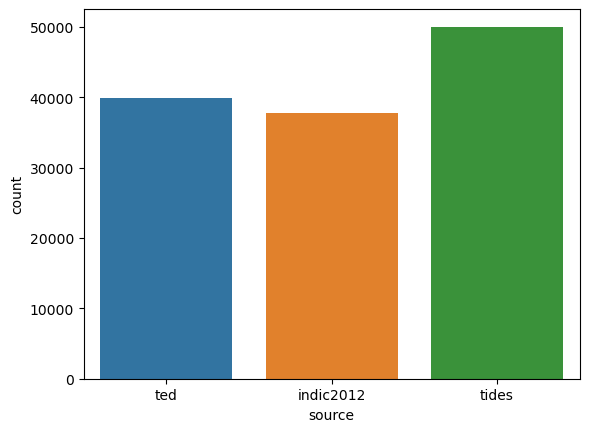

In [4]:

sns.countplot(data['source'],data = data)
plt.show()

In [5]:
print("Total data: ",data.shape[0])

Total data:  127607


In [6]:
# selcting data with source ted
data = data[data.source == 'ted']
data.shape

(39881, 3)

In [7]:
# checking null values
data.isna().sum()

source              0
english_sentence    0
hindi_sentence      0
dtype: int64

In [8]:
# checking duplicated data
isDuplicated = data.duplicated().any()
if isDuplicated:
    total_duplicates = data.duplicated().sum()
    print("Total duplicate rows are: ",total_duplicates)
    data.drop_duplicates(inplace = True)

Total duplicate rows are:  1078


In [9]:
## sampling 20000 rows randomly
data = data.sample(n = 20000, random_state = 31)
data.shape

(20000, 3)

## Text preprocessing

In [10]:
## changing uppercase to lowercase
data['english_sentence'] = data['english_sentence'].apply(lambda x: x.lower())
data['hindi_sentence']=data['hindi_sentence'].apply(lambda x: x.lower())

# Remove quotes
data['english_sentence']=data['english_sentence'].apply(lambda x: re.sub("'", '', x))
data['hindi_sentence']=data['hindi_sentence'].apply(lambda x: re.sub("'", '', x))


In [11]:
to_exclude = set(string.punctuation) # Set of all special characters
print("punctuations to exclude:: ",to_exclude)
# Remove all the special characters
data['english_sentence']=data['english_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in to_exclude))
data['hindi_sentence']=data['hindi_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in to_exclude))

punctuations to exclude::  {'"', '-', '`', '!', '<', '@', '}', '?', ')', '=', '/', '^', '(', '{', '|', '_', ',', ';', '&', '\\', ']', "'", '>', '+', '*', '[', '#', '.', ':', '%', '~', '$'}


In [12]:
from string import digits
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)

data['english_sentence']=data['english_sentence'].apply(lambda x: x.translate(remove_digits))
data['hindi_sentence']=data['hindi_sentence'].apply(lambda x: x.translate(remove_digits))

data['hindi_sentence'] = data['hindi_sentence'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

# Remove extra spaces
data['english_sentence']=data['english_sentence'].apply(lambda x: x.strip())
data['hindi_sentence']=data['hindi_sentence'].apply(lambda x: x.strip())
data['english_sentence']=data['english_sentence'].apply(lambda x: re.sub(" +", " ", x))
data['hindi_sentence']=data['hindi_sentence'].apply(lambda x: re.sub(" +", " ", x))

In [13]:
## adding start and end token to the target sentence
data['hindi_sentence'] = data['hindi_sentence'].apply(lambda x: "START_ " + x + " _END")

In [14]:
## counting length of english and hindi sentence
data['english_length'] = data['english_sentence'].apply(lambda x: len(x.split(' ')))
data['hindi_length'] = data['hindi_sentence'].apply(lambda x: len(x.split(' ')))

data.head()

,source,english_sentence,hindi_sentence,english_length,hindi_length
123152,ted,is not about belief but about behavior,START_ वो विश्वास के बारे में नहीं वरन लेकिन व...,7,14
31468,ted,than the story were going to tell about it later,START_ उससे जो हम बाद में बताने वाले हैं _END,10,10
102720,ted,and if they need a pair of glasses they are av...,START_ यदि किसी को चश्मे की ज़रूरत है तो उसे श...,17,19
40273,ted,the feedback here is immediate,START_ यहाँ तुरंत नतीजा मिलता है _END,5,7
17027,ted,a rather astonishing demonstration of the abil...,START_ यह दिमाग की एक अद्भुत क्षमता का प्रदर्श...,10,11


In [15]:
print("Maximum length of English Sentence: ", max(data['english_length']))
print("Maximum length of Hindi Sentence: ",max(data['hindi_length']))

Maximum length of English Sentence:  21
Maximum length of Hindi Sentence:  32


In [16]:
### Get English and Hindi Vocabulary
all_eng_words=set()
for eng in data['english_sentence']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

all_hindi_words=set()
for hin in data['hindi_sentence']:
    for word in hin.split():
        if word not in all_hindi_words:
            all_hindi_words.add(word)
            

print("toral english words: ",len(all_eng_words))
print('total hind words: ',len(all_hindi_words))

toral english words:  12483
total hind words:  15529


In [17]:
## using only sentence with length less than 20
mask1 = data['english_length'] < 21
mask2 = data['hindi_length'] < 21
data = data[mask1 & mask2]
data.shape

(19830, 5)

In [18]:
print("maximum length of Hindi Sentence ",max(data['hindi_length']))
print("maximum length of English Sentence ",max(data['english_length']))

maximum length of Hindi Sentence  20
maximum length of English Sentence  20


In [19]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_hindi_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_hindi_words)

num_encoder_tokens, num_decoder_tokens

(12483, 15529)

In [20]:
num_decoder_tokens += 1 #for zero padding
num_encoder_tokens += 1

In [21]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])
print("Token for accelerating is: ",input_token_index['accelerating'])


Token for accelerating is:  50


In [22]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())
print("Character for toker 50 is: ",reverse_input_char_index[50])

Character for toker 50 is:  accelerating


In [23]:
# splitting data
X_, y_ = data['english_sentence'], data['hindi_sentence']
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size = 0.2,random_state=42)
print("Total number of training data: ",X_train.shape[0])
print("Toral number of testing data: ",X_test.shape[0])

Total number of training data:  15864
Toral number of testing data:  3966


In [24]:
latent_dim = 300
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]


# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 300)    3745200     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 300)    4659000     ['input_2[0][0]']                
                                                                                              

In [25]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics = ['accuracy'])

In [26]:
max_length_src = 20
max_length_tar = 20 

def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [27]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 5

In [ ]:
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

Epoch 1/5
123/123 [==============================] - 1678s 13s/step - loss: 3.0208 - accuracy: 0.1292 - val_loss: 2.9208 - val_accuracy: 0.1386
Epoch 2/5
123/123 [==============================] - 2749s 22s/step - loss: 2.7737 - accuracy: 0.1510 - val_loss: 2.7859 - val_accuracy: 0.1693
Epoch 3/5
123/123 [==============================] - 1365s 11s/step - loss: 2.6105 - accuracy: 0.1843 - val_loss: 2.6893 - val_accuracy: 0.1932
Epoch 4/5
123/123 [==============================] - 1359s 11s/step - loss: 2.4942 - accuracy: 0.2037 - val_loss: 2.6507 - val_accuracy: 0.2037
Epoch 5/5
 87/123 [====================>.........] - ETA: 5:17:41 - loss: 2.4146 - accuracy: 0.2168

In [ ]:
# Encode the input sequence to get the "thought vectors"
encoder_model = tf.keras.Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = tf.keras.Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [ ]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k = -1

In [ ]:

k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

In [ ]:
k = k + 1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

In [ ]:
k = k + 1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

In [ ]:
k = k + 1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

In [ ]:
k = k + 1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

In [ ]:
k = k + 1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])